In [17]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import random
import os

In [18]:
train_df = pd.read_csv('/kaggle/input/ml-hackathon-ec-campus-set-1/train.csv', encoding='ISO-8859-1')
# Define path to video clips
video_dir = '/kaggle/input/ml-hackathon-ec-campus-set-1/train_videos'


# Function to get video file path from IDs
def get_video_clip_path(row):
    dialogue_id = row['Dialogue_ID']
    utterance_id = row['Utterance_ID']
    filename = f"dia{dialogue_id}_utt{utterance_id}.mp4"
    return os.path.join(video_dir, filename)

# Apply the function to get file paths for each sampled clip
train_df['video_clip_path'] = train_df.apply(get_video_clip_path, axis=1)

# Check sample paths
print(train_df[['Dialogue_ID', 'Utterance_ID', 'video_clip_path']].head())

   Dialogue_ID  Utterance_ID  \
0            1             3   
1            1             8   
2            2             4   
3            2             8   
4            3             4   

                                     video_clip_path  
0  /kaggle/input/ml-hackathon-ec-campus-set-1/tra...  
1  /kaggle/input/ml-hackathon-ec-campus-set-1/tra...  
2  /kaggle/input/ml-hackathon-ec-campus-set-1/tra...  
3  /kaggle/input/ml-hackathon-ec-campus-set-1/tra...  
4  /kaggle/input/ml-hackathon-ec-campus-set-1/tra...  


In [19]:
train_df.shape

(999, 11)

In [20]:
# Define path to video clips
df = pd.read_csv('/kaggle/input/ml-hackathon-ec-campus-set-1/test.csv', encoding='ISO-8859-1')
video_dir = '/kaggle/input/ml-hackathon-ec-campus-set-1/test_videos'


# Function to get video file path from IDs
def get_video_clip_path(row):
    dialogue_id = row['Dialogue_ID']
    utterance_id = row['Utterance_ID']
    filename = f"dia{dialogue_id}_utt{utterance_id}.mp4"
    return os.path.join(video_dir, filename)

# Apply the function to get file paths for each sampled clip
df['video_clip_path'] = df.apply(get_video_clip_path, axis=1)

# Check sample paths
print(df[['Dialogue_ID', 'Utterance_ID', 'video_clip_path']].head())

   Dialogue_ID  Utterance_ID  \
0            3             5   
1            8             3   
2           15             2   
3           16             0   
4           23             2   

                                     video_clip_path  
0  /kaggle/input/ml-hackathon-ec-campus-set-1/tes...  
1  /kaggle/input/ml-hackathon-ec-campus-set-1/tes...  
2  /kaggle/input/ml-hackathon-ec-campus-set-1/tes...  
3  /kaggle/input/ml-hackathon-ec-campus-set-1/tes...  
4  /kaggle/input/ml-hackathon-ec-campus-set-1/tes...  


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss

In [22]:
#print(train_df.head())
sentences = train_df[["Utterance","Sentiment"]].values
sentences = pd.DataFrame(sentences)

sentences_test = df["Utterance"].values
sentences_test = pd.DataFrame(sentences_test)

sentences.columns = ['Text', 'Sentiment']
print(sentences)

sentences_test.columns = ['Text']
print(sentences_test)

                                                  Text Sentiment
0             No, I-I-I-I don't, I actually don't know  negative
1                                          Yeah, sure!   neutral
2                                              No way!  negative
3                                    Can I get a beer.   neutral
4      Look,  'My vessel so empty with nothing inside.   neutral
..                                                 ...       ...
994  Oh yeah, I still hang with Simmons and Zana, y...   neutral
995              So the Porsche guy took his car back.   neutral
996  Eh, worth a shot.  Look Joey, let me know wher...   neutral
997  I'm tellin' you, she leaned back; I could see ...  negative
998                                         You or me?   neutral

[999 rows x 2 columns]
                                                 Text
0                      Ugh, can you believe that guy!
1                                              Bumpy?
2                                 

Epoch 1/3 completed.
Epoch 2/3 completed.
Epoch 3/3 completed.
              precision    recall  f1-score   support

    negative       0.65      0.61      0.63        88
    positive       0.74      0.43      0.54        72
     neutral       0.71      0.89      0.79       140

    accuracy                           0.70       300
   macro avg       0.70      0.65      0.66       300
weighted avg       0.70      0.70      0.69       300



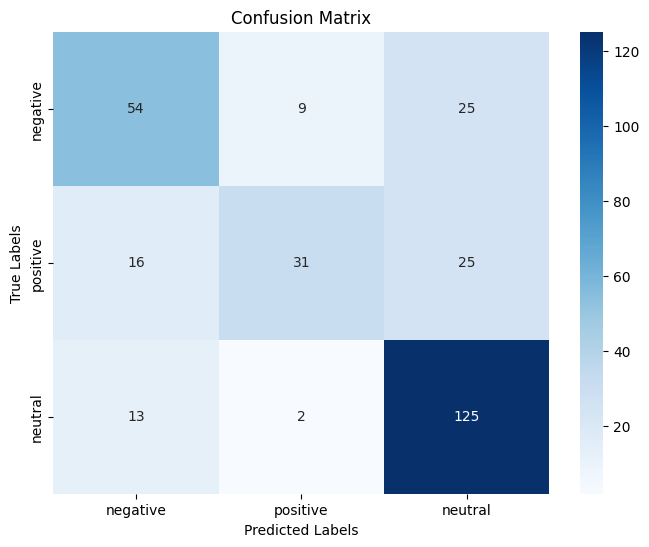

In [23]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# Example DataFrame (replace with your actual sentences)
# sentences = pd.DataFrame({'Text': ["I love this!", "I hate that", "This is okay"], 'Sentiment': ['positive', 'negative', 'neutral']})

# Encode sentiments into numeric labels
sentences['Sentiment'] = sentences['Sentiment'].map({'positive': 1, 'negative': 0, 'neutral': 2})

# Split the data into training and testing sets
train_data, test_data = train_test_split(sentences, test_size=0.3, random_state=42)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create custom Dataset class
class SentimentDataset(Dataset):
    def __init__(self, sentences, tokenizer, max_length=128):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.texts = sentences['Text'].values
        self.labels = sentences['Sentiment'].values

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Encode text using BERT tokenizer
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Prepare DataLoader
train_dataset = SentimentDataset(train_data, tokenizer)
test_dataset = SentimentDataset(test_data, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        # Move batch to GPU if available
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        
        # Optimizer step
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs} completed.")

# Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Print classification report for 3 sentiment classes
print(classification_report(true_labels, predictions, target_names=['negative', 'positive', 'neutral']))
cm=confusion_matrix(true_labels,predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive', 'neutral'], yticklabels=['negative', 'positive', 'neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Assuming `test_data` contains only 'Text' column without the 'Sentiment' column
# Replace the previous evaluation section with the following code

test_sentences = sentences_test['Text'].values  # Only the text for prediction

# Create a dataset for test data without labels
class TestSentimentDataset(Dataset):
    def __init__(self, sentences, tokenizer, max_length=128):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.texts = sentences

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        
        # Encode text using BERT tokenizer
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Prepare DataLoader for test data
test_dataset = TestSentimentDataset(test_sentences, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Make predictions on the test dataset
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())

# Map predictions back to sentiment labels
sentiment_labels = ['negative', 'positive', 'neutral']
predicted_sentiments = [sentiment_labels[pred] for pred in predictions]

all_preds = predicted_sentiments

submission_df = pd.DataFrame({
        'ID': range(1,len(test_sentences)+1),
        'Emotion': all_preds
    })
    
# Save the DataFrame to CSV
submission_df.to_csv("submission.csv", index=False)


In [25]:
!pip install moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 8.5 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 62.8 MB/s eta 0:00:00:00:0100:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110721 sha256=3a4334163ad0d3cfa5cebdad18e91ea8e3f7841bff9fb1248a53bd45fe25a065
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


In [26]:
from moviepy.editor import VideoFileClip
import os

# Path to the video directory
video_dir = "/kaggle/input/ml-hackathon-ec-campus-set-1/train"  # Your video folder path

# Create a directory to store audio files
audio_dir = "/kaggle/working/audio_files"
os.makedirs(audio_dir, exist_ok=True)

# Iterate through all video files in the directory
for filename in os.listdir(video_dir):
    if filename.endswith(('.mp4', '.avi', '.mov')):  # Adjust extensions as needed
        video_path = os.path.join(video_dir, filename)
        
        # Load video file
        video_clip = VideoFileClip(video_path)
        
        # Extract audio from the video
        audio_clip = video_clip.audio
        
        # Save the audio file
        audio_filename = os.path.splitext(filename)[0] + '.mp3'  # You can also use .wav
        audio_path = os.path.join(audio_dir, audio_filename)
        audio_clip.write_audiofile(audio_path)
        
        # Close clips after processing to free resources
        video_clip.close()
        audio_clip.close()

print("Audio extraction complete!")

MoviePy - Writing audio in /kaggle/working/audio_files/dia40_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia590_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia421_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia258_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia337_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia554_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia40_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia886_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia449_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia676_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia733_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia778_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia936_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia73_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia430_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia562_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia351_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia670_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia676_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia279_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia2_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia859_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia319_utt12.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia727_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia148_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia812_utt14.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia842_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia505_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia982_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia576_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia809_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia930_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia249_utt13.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia778_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia457_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia669_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia796_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia718_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia792_utt17.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia398_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia946_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia179_utt14.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1007_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia735_utt18.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1007_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia474_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia893_utt14.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia462_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia575_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia222_utt17.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia975_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia717_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia942_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia804_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia954_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia523_utt16.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia623_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia747_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia930_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia351_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia561_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia680_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia809_utt14.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1012_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia383_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia509_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia939_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia439_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia252_utt17.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia996_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia64_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia961_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia336_utt20.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia917_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia841_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia519_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia414_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia747_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia908_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia827_utt14.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia49_utt18.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia314_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia962_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia707_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia947_utt15.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia277_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia737_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia596_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia221_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia886_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia939_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia430_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia21_utt10.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia279_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia130_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia679_utt16.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia792_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia625_utt14.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia249_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia521_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia34_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia119_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1012_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia312_utt19.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia948_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia506_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia175_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia947_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia680_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia4_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia792_utt14.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia690_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1012_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia665_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia939_utt14.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia727_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia72_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia796_utt19.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia163_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia47_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia909_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia20_utt13.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1033_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia678_utt18.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1026_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia886_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia342_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia49_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia894_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia576_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia47_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia891_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia462_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia851_utt15.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia70_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia420_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia587_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia275_utt13.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia712_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia881_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1022_utt15.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia629_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia284_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia499_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia41_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia905_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia949_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia696_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia646_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia886_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia867_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia431_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia383_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia740_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia655_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia334_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia991_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia910_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia448_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia745_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia590_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia208_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia513_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia177_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia840_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia508_utt16.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia424_utt12.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia171_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia484_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia597_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia661_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia664_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia737_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia854_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia556_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia32_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia293_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia206_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia180_utt13.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia538_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia152_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia292_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia933_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia908_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia415_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia970_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia689_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia222_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia949_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1038_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia971_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia78_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia30_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia185_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia855_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia681_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia446_utt15.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia436_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia5_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia886_utt20.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia655_utt15.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia182_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia866_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia256_utt15.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia775_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia506_utt10.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia206_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia902_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia986_utt15.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia457_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia573_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia803_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia658_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia812_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia130_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia115_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia406_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia112_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia834_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia148_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia50_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia543_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia588_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia643_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia207_utt19.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia245_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia292_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia623_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia226_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia791_utt21.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia211_utt13.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia295_utt18.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia377_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia499_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia418_utt19.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia896_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia112_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia602_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia945_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia511_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia202_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia960_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia225_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia515_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia705_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia514_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia845_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia782_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia649_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia312_utt16.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1007_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia770_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia635_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia839_utt15.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia847_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia949_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia904_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia354_utt16.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia908_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia952_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia507_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia155_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia264_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia304_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia554_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia190_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia839_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia29_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia601_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia973_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia950_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia231_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia383_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia309_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia923_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia850_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia119_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia242_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia842_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia261_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia18_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia361_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia452_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia867_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia804_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia799_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia546_utt18.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia796_utt20.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia525_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia145_utt18.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia429_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia360_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia614_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia916_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia548_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia330_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia8_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia465_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia170_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia445_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia452_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia451_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia337_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia644_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia318_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia942_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia148_utt19.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia546_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia70_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia11_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia122_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia179_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia948_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia365_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia464_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia719_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia902_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia389_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia76_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia126_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia943_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia866_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia33_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia659_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia125_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia756_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia344_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia79_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia216_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia843_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia287_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia672_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia676_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia672_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia72_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia177_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia379_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1025_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia604_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia753_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia174_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia643_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia37_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia652_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia443_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia97_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia635_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia600_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia722_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia228_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia599_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia986_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia372_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia21_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia657_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia712_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia720_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia212_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia557_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia587_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia750_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia617_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia723_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia488_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia622_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia275_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia301_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia626_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia374_utt15.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia877_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia726_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia488_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia129_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia512_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia856_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia863_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia871_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia477_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1003_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia153_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia149_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia179_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia973_utt10.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia933_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia806_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia938_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia565_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia471_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia777_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia272_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia537_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia689_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia589_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia933_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia23_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia441_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia34_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia271_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia81_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia195_utt16.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia806_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1026_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia843_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia338_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia132_utt10.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia952_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia235_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia895_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia930_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia604_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1011_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia183_utt15.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia739_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia562_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia571_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia21_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia935_utt12.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia585_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia132_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia293_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia699_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia655_utt13.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia327_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia796_utt14.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia273_utt15.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia503_utt15.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia724_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia279_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia455_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia231_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia989_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia819_utt17.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia966_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia46_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia392_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia897_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia966_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia388_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia20_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia279_utt14.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia137_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia179_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia861_utt17.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia548_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia669_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia518_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia81_utt15.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia948_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia670_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia288_utt20.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia625_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia231_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia713_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1018_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia404_utt19.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia904_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia478_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia947_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia510_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia710_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia858_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia100_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia332_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia63_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia615_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia673_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia307_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia574_utt13.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia788_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia728_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia637_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia232_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia762_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia415_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia895_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia789_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia678_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia507_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia645_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia922_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia400_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia35_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia889_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia344_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia250_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia649_utt18.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia74_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia763_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia450_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia606_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia735_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia864_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia770_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia146_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia845_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia526_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia374_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia923_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia771_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia376_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia239_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia418_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia774_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia113_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia319_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia596_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia493_utt12.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia517_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia236_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia655_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia982_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia167_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia475_utt15.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia426_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia301_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia900_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia34_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia997_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia608_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1029_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia231_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia679_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia506_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia662_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia232_utt17.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia208_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia916_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia156_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia128_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia344_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia314_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia550_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia420_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia841_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia283_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia926_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia411_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia887_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia476_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia723_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia973_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1023_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia686_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia841_utt16.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia645_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia605_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia425_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia388_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia310_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia674_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia964_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia255_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia419_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia777_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia321_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia860_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia341_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1029_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia826_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia29_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia458_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia722_utt16.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia74_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia892_utt15.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia942_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia445_utt17.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia242_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia578_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia53_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia166_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia584_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia886_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia255_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia666_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia596_utt15.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia273_utt16.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia526_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia129_utt14.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia888_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia17_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia122_utt12.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia376_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia755_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia612_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia629_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia146_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia287_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia820_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1014_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia21_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia223_utt10.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia884_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia536_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia703_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia443_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1003_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1032_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia21_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia232_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia441_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia21_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia676_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia945_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia361_utt13.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia578_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia38_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia82_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia509_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia197_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia324_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia615_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia383_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia659_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia390_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia696_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia61_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia140_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia836_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia577_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia640_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia855_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia144_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia429_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia192_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1018_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia853_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia961_utt14.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia231_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia864_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia19_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia455_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia603_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia849_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia78_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia821_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia907_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia91_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia740_utt13.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia94_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia947_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia486_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia2_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia796_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia189_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia972_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia317_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia665_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia264_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia629_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia6_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia12_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia306_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia804_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia671_utt16.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia979_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia954_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia537_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia759_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia352_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia446_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia531_utt15.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia966_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia561_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia897_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia336_utt19.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia720_utt15.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia872_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia243_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia535_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia367_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia295_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia541_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia320_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia316_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia132_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1021_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia358_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia607_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia949_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia247_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia67_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia508_utt19.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia320_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia222_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia3_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia836_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia792_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia797_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia546_utt15.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia589_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia617_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia597_utt10.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia480_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia201_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia623_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia389_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia755_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia420_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia571_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia687_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia475_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia215_utt0.mp3

MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia832_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia576_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia110_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia139_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia898_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia416_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia180_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia115_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia760_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia522_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia503_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia574_utt10.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia486_utt12.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia707_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia549_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia203_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia791_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia252_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia231_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia12_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia736_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia446_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia450_utt18.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia920_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia139_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia7_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia576_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia924_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia432_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia690_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia707_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia171_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia508_utt21.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia99_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia774_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia15_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia142_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia351_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia444_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia983_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia313_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia288_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia189_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia388_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia759_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia509_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1016_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia740_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia304_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia305_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia76_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia46_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia409_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia805_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia86_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia962_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia542_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia431_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia160_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia712_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia123_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia462_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia361_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia719_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia516_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia549_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia931_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia806_utt17.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia170_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia963_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia728_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia670_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia966_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia322_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia659_utt14.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia717_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia204_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia219_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia257_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia477_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia199_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia124_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia667_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia604_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia314_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia146_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia165_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia778_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia533_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia466_utt13.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia279_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia109_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia851_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia760_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia857_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia287_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia281_utt10.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia202_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia40_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia887_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia8_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia717_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia612_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia907_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia295_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia634_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia821_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia622_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia988_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia357_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia273_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia791_utt15.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia965_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia990_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia936_utt12.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia793_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia527_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia305_utt14.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia809_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia789_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia893_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia678_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia947_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia312_utt18.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia735_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia47_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1011_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia449_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia878_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia482_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia344_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia79_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia905_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia367_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1014_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia657_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia270_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia231_utt12.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia813_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia839_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia902_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1008_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia635_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia482_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia792_utt16.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia773_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia679_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia111_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia172_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia563_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia69_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia553_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia733_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia658_utt14.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia852_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia613_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia301_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1036_utt16.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia787_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia450_utt15.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia761_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia169_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia395_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia445_utt14.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia853_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia991_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia844_utt20.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia226_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia705_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia737_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1024_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia660_utt12.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia365_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia861_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia907_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia977_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia41_utt13.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia703_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia996_utt17.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia222_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia338_utt13.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia608_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia589_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia515_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia20_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia177_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia980_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia842_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia932_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia722_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia259_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia823_utt11.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia868_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia977_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia59_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia193_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia99_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia530_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia179_utt18.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia481_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia819_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia895_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia263_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia625_utt19.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia821_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia451_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia503_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1025_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1009_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia782_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia716_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia423_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia200_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia604_utt13.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1009_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia203_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia38_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia7_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia506_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia719_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia405_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia483_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia182_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia596_utt21.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia810_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia25_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia916_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia500_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia953_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia964_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia604_utt11.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia125_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia623_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia268_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia438_utt10.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia794_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia822_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia25_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia46_utt12.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia148_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia477_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1038_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia754_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia754_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia789_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia328_utt8.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia752_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia888_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia406_utt2.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1012_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia678_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia857_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia241_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia653_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia119_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia52_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia817_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia644_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia623_utt17.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia1002_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia573_utt3.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia596_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia658_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia840_utt7.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia699_utt5.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia817_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia806_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia820_utt10.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia401_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia952_utt6.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia726_utt1.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia561_utt9.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia933_utt19.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia456_utt10.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia794_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia680_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia707_utt3.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia15_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia822_utt7.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia454_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia223_utt6.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia366_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia507_utt4.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia240_utt1.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia371_utt4.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia82_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia483_utt12.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia564_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia137_utt5.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia641_utt0.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia523_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1026_utt0.mp3


MoviePy - Done.


MoviePy - Writing audio in /kaggle/working/audio_files/dia910_utt2.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia185_utt9.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia1_utt8.mp3


MoviePy - Done.
MoviePy - Writing audio in /kaggle/working/audio_files/dia757_utt5.mp3


MoviePy - Done.
Audio extraction complete!


In [27]:
import librosa
import numpy as np
import os

# Path to your audio files directory
audio_dir = "/kaggle/working/audio_files"  # Update with your path

# Function to extract MFCC features from an audio file
def extract_audio_features(audio_file):
    # Load audio file
    y, sr = librosa.load(audio_file, sr=None)
    
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    # Mean of the MFCC features across time
    mfcc_mean = np.mean(mfcc, axis=1)
    
    return mfcc_mean

# Extract features for all audio files
audio_features = []
audio_filenames = []

for filename in os.listdir(audio_dir):
    if filename.endswith('.mp3'):  # Adjust file extensions as needed
        audio_file_path = os.path.join(audio_dir, filename)
        features = extract_audio_features(audio_file_path)
        audio_features.append(features)
        audio_filenames.append(filename)

# Convert to numpy array
audio_features = np.array(audio_features)

In [28]:
import pandas as pd

# Load the dataset with ISO-8859-1 encoding
file_path = "/kaggle/input/ml-hackathon-ec-campus-set-1/train.csv"  # Replace with your actual CSV file path
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Preview the data to check the columns
print(df.head())

# Check for missing values
print(df.isnull().sum())


# Drop rows with missing 'Utterance' or 'Sentiment' columns
df = df.dropna(subset=['Utterance', 'Sentiment'])

# Preview cleaned data
print(df[['Utterance', 'Sentiment']].head())

   Sr No.                                        Utterance   Speaker  \
0      18         No, I-I-I-I don't, I actually don't know    Rachel   
1      23                                      Yeah, sure!    Rachel   
2      28                                          No way!  Chandler   
3      32                                Can I get a beer.  Chandler   
4      41  Look,  'My vessel so empty with nothing inside.    Phoebe   

  Sentiment  Dialogue_ID  Utterance_ID  Season  Episode     StartTime  \
0  negative            1             3       9       23  00:36:49,290   
1   neutral            1             8       9       23   0:36:59,425   
2  negative            2             4       3        6   0:05:58,734   
3   neutral            2             8       3        6   0:06:07,367   
4   neutral            3             4       3       12  00:10:23,664   

        EndTime  
0  00:36:51,791  
1   0:37:01,439  
2   0:05:59,774  
3   0:06:08,035  
4  00:10:26,499  
Sr No.          0
Ut

In [29]:
from transformers import pipeline

# Initialize the sentiment analysis pipeline using BERT
sentiment_analyzer = pipeline("sentiment-analysis")

# Function to analyze sentiment of the utterance
def analyze_text_sentiment(text):
    result = sentiment_analyzer(text)
    sentiment = result[0]['label']  # "POSITIVE" or "NEGATIVE"
    return sentiment

# Apply sentiment analysis to each utterance
df['Predicted_Sentiment'] = df['Utterance'].apply(analyze_text_sentiment)

# Map BERT sentiment output to numeric labels (positive: 1, negative: 0, neutral: 2)
def sentiment_to_label(sentiment):
    if sentiment == 'POSITIVE':
        return 1
    elif sentiment == 'NEGATIVE':
        return 0
    else:
        return 2  # Neutral

df['Predicted_Sentiment_Label'] = df['Predicted_Sentiment'].apply(sentiment_to_label)

# Preview the updated dataframe
print(df[['Utterance', 'Sentiment', 'Predicted_Sentiment', 'Predicted_Sentiment_Label']].head())

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


                                         Utterance Sentiment  \
0         No, I-I-I-I don't, I actually don't know  negative   
1                                      Yeah, sure!   neutral   
2                                          No way!  negative   
3                                Can I get a beer.   neutral   
4  Look,  'My vessel so empty with nothing inside.   neutral   

  Predicted_Sentiment  Predicted_Sentiment_Label  
0            NEGATIVE                          0  
1            POSITIVE                          1  
2            NEGATIVE                          0  
3            POSITIVE                          1  
4            NEGATIVE                          0  


In [30]:
from sklearn.metrics import accuracy_score, classification_report

# Convert actual sentiment to numeric labels (positive: 1, negative: 0, neutral: 2)
def actual_sentiment_to_label(sentiment):
    if sentiment == 'positive':
        return 1
    elif sentiment == 'negative':
        return 0
    else:
        return 2  # Neutral

# Apply this function to the actual 'Sentiment' column
df['Actual_Sentiment_Label'] = df['Sentiment'].apply(actual_sentiment_to_label)

# Calculate the accuracy
accuracy = accuracy_score(df['Actual_Sentiment_Label'], df['Predicted_Sentiment_Label'])
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate a classification report
print("Classification Report:\n", classification_report(df['Actual_Sentiment_Label'], df['Predicted_Sentiment_Label']))

Accuracy: 37.34%
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.71      0.52       294
           1       0.34      0.70      0.45       233
           2       0.00      0.00      0.00       472

    accuracy                           0.37       999
   macro avg       0.25      0.47      0.32       999
weighted avg       0.20      0.37      0.26       999

